## Captcha Image generate

In [1]:
from captcha.image import ImageCaptcha
import random
import os

In [2]:
os.system('rm TrainImage/*')
os.system('rm TestImage/*')

random.seed()
captcha_len = 4
TrainImageNum = 3000
TestImageNum = 100

In [3]:
for i in range(TrainImageNum): #Generate train img
    #img content
    gen_string=''
    for j in range(captcha_len):
        gen_string += str(random.randint(0,9))
    
    #output to img
    cap = ImageCaptcha()
    cap.write(gen_string,'TrainImage/'+gen_string+'_'+str(random.randint(0,10000))+'.jpg')

print('%d Train image generated'%(TrainImageNum))    

for i in range(TestImageNum): #Generate test img
    #img content
    gen_string=''用
    for j in range(captcha_len):
        gen_string += str(random.randint(0,9))
    
    #output to img
    cap = ImageCaptcha()
    cap.write(gen_string,'TestImage/'+gen_string+'.jpg')

print('%d Test image generated'%(TestImageNum))    

3000 Train image generated
100 Test image generated


## CNN model

In [4]:
import numpy as np
from PIL import Image
from PIL import ImageEnhance
from sklearn import preprocessing
import os
import tensorflow.keras as keras
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = InteractiveSession(config=config)

In [5]:
#Get train image name
fileName=[]
for i in os.listdir('TrainImage/'):
    fileName.append(i)

#Get train image size
img = Image.open('TrainImage/'+fileName[0]).convert('L')
width,height = img.size

In [6]:
# name2label( '0492_0000.jpg' ,1) will return [0,0,0,0,1,0,0,0,0,0] <- 4
def name2label(filename,digit):
    target = int(filename[digit])
    label = np.zeros(10)
    label[target]=1
    return label

def imagePreprocess(lst):
    for i in range( len(lst) ):
        img = lst[i]
        enhancer = ImageEnhance.Contrast(img) #increase contrast
        img = enhancer.enhance(4.0)
        img = np.asarray(img)
        img = img.astype('float32')
        img/=255
        lst[i]=img
    
    lst=np.array(lst)
    lst=lst.reshape(lst.shape[0],height,width,1)
    return lst

In [7]:
#Read x_train & y_train
imgList=[]
y_train=[]
for i in range(captcha_len):
    y_train.append([])
    
for i in fileName:
    img = Image.open('TrainImage/'+i).convert('L')
    imgList.append(img)
    for j in range(captcha_len):
        y_train[j].append(name2label(i,j))
        
x_train=imagePreprocess(imgList)
y_train = [y_train for y_train in np.asarray(y_train)]

(3000, 60, 160, 1)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
import tensorflow as tf

In [35]:
inf = layers.Input((height,width,1))
out = inf
out = layers.Conv2D(32,3,padding='same',activation='relu')(out)
out = layers.Conv2D(32,3,padding='same',activation='relu')(out)
out = layers.BatchNormalization()(out)
out = layers.MaxPooling2D(pool_size=(2,2))(out)


out = layers.Conv2D(64,3,padding='same',activation='relu')(out)
out = layers.Conv2D(64,3,padding='same',activation='relu')(out)
out = layers.BatchNormalization()(out)
out = layers.MaxPooling2D(pool_size=(2,2))(out)

out = layers.Conv2D(64,3,padding='same',activation='relu')(out)
out = layers.Conv2D(64,3,padding='same',activation='relu')(out)
out = layers.BatchNormalization()(out)
out = layers.MaxPooling2D(pool_size=(2,2))(out)

out = layers.Conv2D(128,3,padding='same',activation='relu')(out)
out = layers.Conv2D(128,3,padding='same',activation='relu')(out)
out = layers.BatchNormalization()(out)
out = layers.MaxPooling2D(pool_size=(2,2))(out)

out=layers.Flatten()(out)
out=layers.Dropout(0.4)(out)
out=layers.Dense(1024,activation='relu')(out)
out=[layers.Dense(10,activation='softmax')(out),layers.Dense(10,activation='softmax')(out),layers.Dense(10,activation='softmax')(out),layers.Dense(10,activation='softmax')(out)]
cnn=models.Model(inf,out)
cnn.summary()
#plot_model(cnn)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 60, 160, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 60, 160, 32)  320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 60, 160, 32)  9248        conv2d_24[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 60, 160, 32)  128         conv2d_25[0][0]                  
_______________________________________________________________________________________

In [36]:
#model train
cnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
94/94 [==============================] - 2s 25ms/step - loss: 9.9032 - dense_16_loss: 2.3846 - dense_17_loss: 2.4685 - dense_18_loss: 2.5226 - dense_19_loss: 2.5275 - dense_16_accuracy: 0.2100 - dense_17_accuracy: 0.1733 - dense_18_accuracy: 0.1683 - dense_19_accuracy: 0.1847
Epoch 2/100
94/94 [==============================] - 2s 25ms/step - loss: 4.6491 - dense_16_loss: 0.8214 - dense_17_loss: 1.3999 - dense_18_loss: 1.4459 - dense_19_loss: 0.9819 - dense_16_accuracy: 0.6937 - dense_17_accuracy: 0.5150 - dense_18_accuracy: 0.5187 - dense_19_accuracy: 0.6490
Epoch 3/100
94/94 [==============================] - 3s 29ms/step - loss: 1.9892 - dense_16_loss: 0.2121 - dense_17_loss: 0.7047 - dense_18_loss: 0.7748 - dense_19_loss: 0.2975 - dense_16_accuracy: 0.9380 - dense_17_accuracy: 0.7727 - dense_18_accuracy: 0.7590 - dense_19_accuracy: 0.9043
Epoch 4/100
94/94 [==============================] - 3s 27ms/step - loss: 0.8474 - dense_16_loss: 0.0906 - dense_17_loss: 0.2865 - de

94/94 [==============================] - 2s 23ms/step - loss: 0.0860 - dense_16_loss: 0.0034 - dense_17_loss: 0.0214 - dense_18_loss: 0.0355 - dense_19_loss: 0.0257 - dense_16_accuracy: 0.9987 - dense_17_accuracy: 0.9960 - dense_18_accuracy: 0.9927 - dense_19_accuracy: 0.9940
Epoch 55/100
94/94 [==============================] - 2s 23ms/step - loss: 0.0730 - dense_16_loss: 0.0119 - dense_17_loss: 0.0071 - dense_18_loss: 0.0390 - dense_19_loss: 0.0149 - dense_16_accuracy: 0.9967 - dense_17_accuracy: 0.9983 - dense_18_accuracy: 0.9933 - dense_19_accuracy: 0.9963
Epoch 56/100
94/94 [==============================] - 2s 24ms/step - loss: 0.0925 - dense_16_loss: 0.0151 - dense_17_loss: 0.0106 - dense_18_loss: 0.0374 - dense_19_loss: 0.0293 - dense_16_accuracy: 0.9967 - dense_17_accuracy: 0.9977 - dense_18_accuracy: 0.9927 - dense_19_accuracy: 0.9943
Epoch 57/100
94/94 [==============================] - 2s 23ms/step - loss: 0.1124 - dense_16_loss: 0.0065 - dense_17_loss: 0.0393 - dense_18_lo

In [37]:
def decode(pred):
    ans=[]
    for target in range(pred[0].shape[0]):
        string=''
        for i in range(captcha_len):
            string+=str(int(np.where( pred[i][target] == max(pred[i][target]) )[0]))
        ans.append(string)
    return ans

In [38]:
#Test image
testName=[]
for i in os.listdir('TestImage/'):
    testName.append('TestImage/'+i)

testList=[]
for i in testName:
    img = Image.open(i).convert('L')
    testList.append(img)
        
temp=testList[1]
x_test=imagePreprocess(testList)
pred=cnn.predict(x_test)
pred=decode(pred)
acc=0
for i in range(len(pred)):
    if pred[i]==testName[i][10:captcha_len+10]:
        acc+=1
print('accurate: ',acc)

accurate:  95


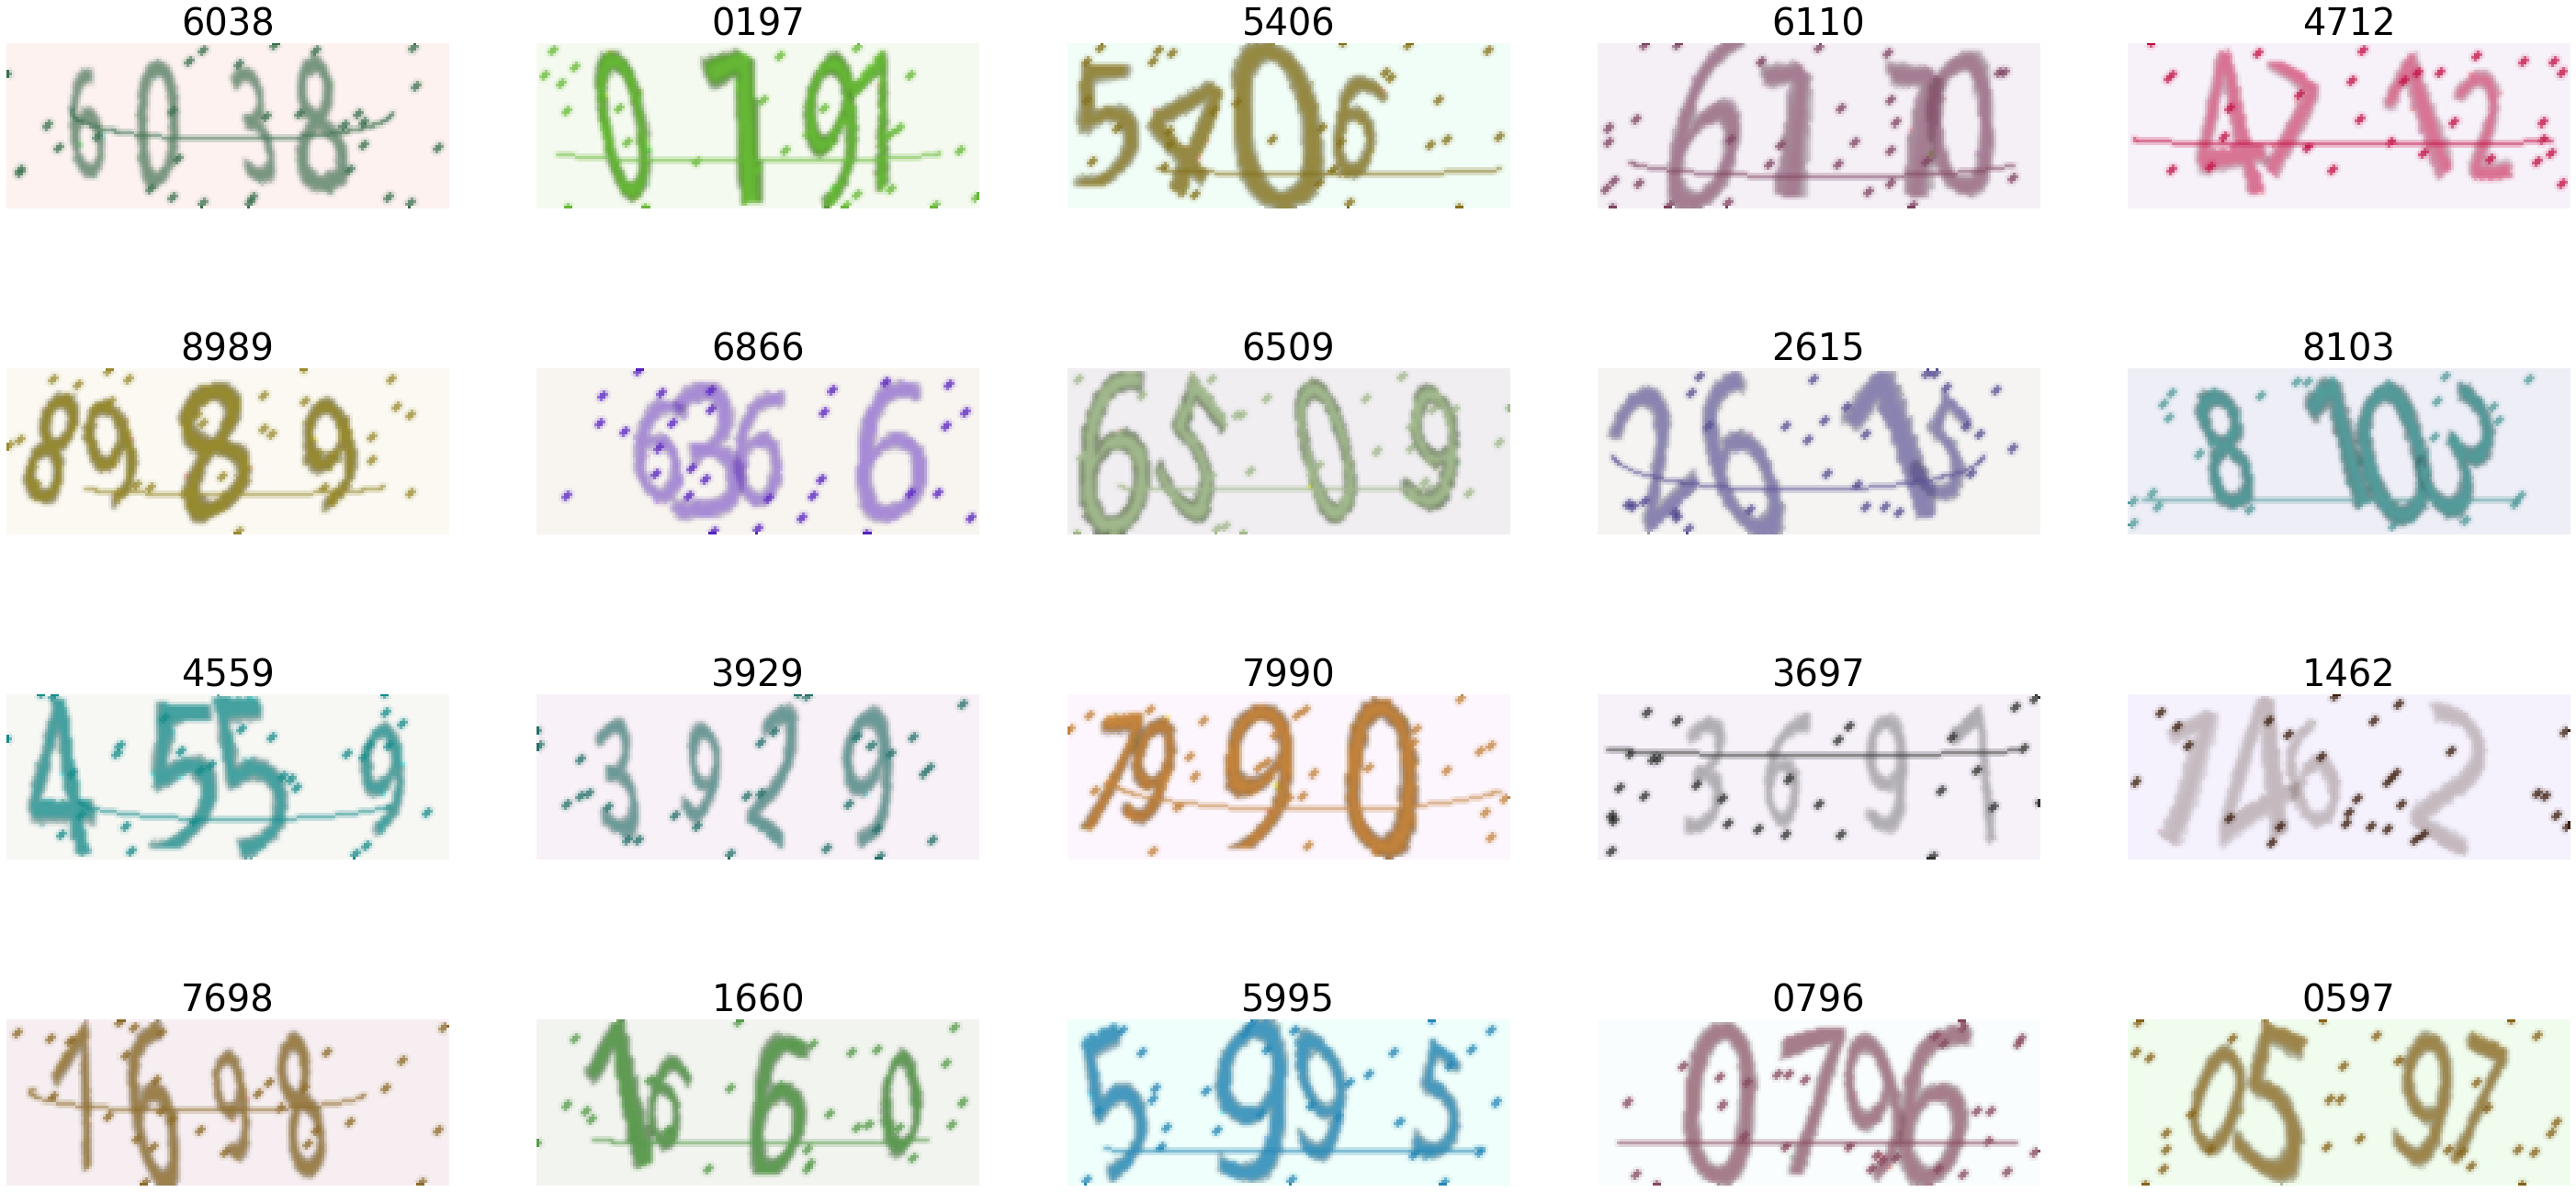

In [39]:
#Show result
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(50,25))
for i in range(20):
    temp=plt.imread(testName[i])
    plt.subplot(4,5,i+1)
    plt.imshow(temp)
    plt.title(pred[i],fontsize=40)
    plt.axis('off')
# result=plt.imread(testName[1])
# plt.imshow(result)
# plt.axis('off')
# print(pred[1])